In [107]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

from sklearn.model_selection import train_test_split

import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/housing.csv')

#dropna use to remove missing values form the dataset
dataset = dataset.dropna()

print('here are te first ten row of the dataset')
dataset.head(10)

here are te first ten row of the dataset


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700,NEAR BAY
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200,NEAR BAY
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400,NEAR BAY
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700,NEAR BAY
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57617a9908>,
      dtype=object)

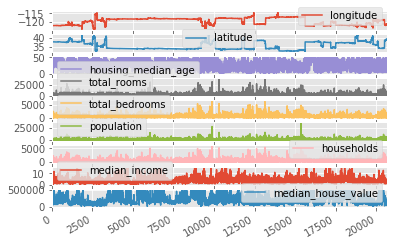

In [109]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
dataset.plot(subplots=True)

In [0]:
# Removes any incomplete rows
dataset = dataset.dropna()

# We will predict the "median_house_value" column
Y = dataset[ 'median_house_value' ]

# The remainder of the columns will be used to predict Y
# Select from the "longitude" column to the "median_income" column
X = dataset.loc[:, 'longitude' :'median_income' ]


In [111]:
X.shape

(20433, 8)

In [112]:
Y.shape

(20433,)

In [113]:
# Splits the dataset so 70% is used for training and 30% for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

#Convert the testing data
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

#View the number of entries in the splits
print("There are " + str(x_train.size) + " training entries and " +
str(x_test.size) + " testing entries!" )


There are 114424 training entries and 49040 testing entries!


In [114]:
x_train.shape

(14303, 8)

In [115]:
y_train.shape

(14303,)

In [116]:
x_test.shape

(6130, 8)

In [0]:
#Importing the pytorch library
import torch

#Importing the 1D convolution layer
from torch.nn import Conv1d

# Importing the max pooling layer
from torch.nn import MaxPool1d

# Importing the flatten layer
from torch.nn import Flatten

# Importing the linear layer
from torch.nn import Linear

# Importing the ReLU activation function
from torch.nn.functional import relu

# to work with datasets we are importing the DataLoader and TensorDataset libraries from PyTorch
from torch.utils.data import DataLoader,TensorDataset


In [0]:
#creating a class
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, batch_size, 1 , 2)

    # First Max pooling layer
    self.max_pooling_layer = MaxPool1d(1)
    #First conv layer
    self.conv_layer = Conv1d(batch_size, 128, 1)

    #adding second max pooling layer
    self.max_pooling_layer1 = MaxPool1d(1)

    #adding second conv layer
    self.conv_layer1 = Conv1d(128, 64, 1)

    #adding flatten layer
    self.flatten_layer = Flatten()

    self.linear_layer = Linear(64, 64)
    self.output_layer = Linear(64, outputs)

  #writing feed method 
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs,1))
    
    output = relu(self.input_layer(input))
    
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))

    output = self.max_pooling_layer1(output)
    output = relu(self.conv_layer1(output))


    output = self.flatten_layer(output)

    output = self.linear_layer(output)
    output = self.output_layer(output)

    return output


In [119]:
#Importing L1Loss 
from torch.nn import L1Loss

!pip install pytorch-ignite

#Importing R2Score
from ignite.contrib.metrics.regression.r2_score import R2Score

In [120]:
batch_size = 32

model = CnnRegressor(batch_size, X.shape[1], 1)

model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 32, kernel_size=(1,), stride=(2,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
  (max_pooling_layer1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predections = model.feed(input)

    loss = performance(predections, output)

    score_metric.update([predections, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
    
    avg_loss += loss.item()

    avg_score += score
    count += 1

  return avg_loss / count, avg_score / count


In [122]:
#Training the model
import time 

epochs = 500

optimizer = torch.optim.RMSprop ( model.parameters(), lr = 1e-2 )

inputs = torch.from_numpy(x_train_np).cuda().float()

#Reshape is used to remove a warning while time of output
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

#Create a DataLoader instance to work with our batches
tensor = TensorDataset (inputs, outputs)
loader = DataLoader ( tensor, batch_size , shuffle = True, drop_last = True)

time1 = time.time()
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

time2 = time.time()
  # if (avg_r2_score>0.20):
    # optimizer = SGD( model.parameters(), lr = 1e-6)
    # print("\n optimizer" + str(optimizer))
    
  # if (avg_r2_score>0.30):
    # optimizer = SGD( model.parameters(), lr = 1e-8)
      # print("\n optimizer" + str(optimizer))



Epoch 1:
	Loss = 95473.33024453475
	R^2 Score = -3.69632399106152
Epoch 2:
	Loss = 80797.14665954316
	R^2 Score = 0.13460333642393543
Epoch 3:
	Loss = 76590.34382882567
	R^2 Score = 0.23645106203727295
Epoch 4:
	Loss = 73760.73986652186
	R^2 Score = 0.28430115951142726
Epoch 5:
	Loss = 72766.16826653587
	R^2 Score = 0.2630106520000833
Epoch 6:
	Loss = 70656.01579140975
	R^2 Score = 0.3277266162027268
Epoch 7:
	Loss = 69873.54570137332
	R^2 Score = 0.3566602551188304
Epoch 8:
	Loss = 68575.42658702354
	R^2 Score = 0.3783048556080477
Epoch 9:
	Loss = 67569.28618098375
	R^2 Score = 0.40084704804688104
Epoch 10:
	Loss = 67313.49756516256
	R^2 Score = 0.388318649339892
Epoch 11:
	Loss = 65811.32949131166
	R^2 Score = 0.42578740077906924
Epoch 12:
	Loss = 65331.93664167601
	R^2 Score = 0.4246335990072801
Epoch 13:
	Loss = 64919.968855100895
	R^2 Score = 0.43908341645566634
Epoch 14:
	Loss = 64313.93089616032
	R^2 Score = 0.4547903961856853
Epoch 15:
	Loss = 63199.9162345852
	R^2 Score = 0.46

In [123]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)

loader = DataLoader(tensor,batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)

print("\nTime Taken: "+ str(time2-time1) +"\nLoss = " + str(avg_loss) + "\nR^2 Score = " + str(avg_r2_score))


Time Taken: 614.1602246761322
Loss = 45061.726746564134
R^2 Score = 0.6950189956235179


In [124]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("The mean squared error is: " + str(mse))

The mean squared error is: 4927590516.896483


In [0]:
torch.save(model,"/content/drive/My Drive/Colab Notebooks/1117269_1dconv_reg.pth")
# model= torch.load("/content/drive/My Drive/NLP/1104361_1dconv_reg.pth")